In [1]:
%matplotlib inline
from rolling_time_series_model import RollingLinearRegression
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [15,8]

if os.name=='nt':
    
    dir_farm='//farmnas/FARM/'

else:
    
    dir_farm='//media/farmshare/'

C:\Users\mchen\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load data

There are 18 features in the predictor matrix including sector returns relative to EW pool and returns of factor hedged portfolios.

In [2]:
df_x=pd.read_csv(dir_farm+'Research/mchen/reports/20181128_risk_model/example/' \
                '20190116_ML2/20190116.csv',index_col=0).dropna()

df_c2c=pd.read_csv(dir_farm+'_JIRA/PAP/PAP-23/Reports/2019-01-12/Reports/' \
                   'ML2_FHD15_TH0.75_Scale_Beta1_Mcap4_BetaTarget0.2/20190112_000411_C2C_report_NET_Tab.csv',index_col=0)
df_y=pd.DataFrame(((df_c2c['Return WITHOUT_COST']-df_c2c['Benchmark Return CloseToClose'])/100).dropna())
df_y.columns=['relret']

### Fit the model on full data set

In [3]:
model=RollingLinearRegression(df_x, df_y)             
df_summary=model.global_fit()

In [4]:
df_summary

,coef,vif,pval,feature_imp
intercept,0.0004,NaN,NaN,NaN
Energy_Local,-0.0216,44.7101,0.0000,0.0675
Materials_Local,-0.0411,5.6954,0.1137,0.0318
Industrials_Local,0.1923,12.7570,0.0000,0.0665
Consumer Discretionary_Local,0.1908,16.8351,0.0182,0.0383
Consumer Staples_Local,0.1028,5.5204,0.0000,0.0478
Health Care_Local,0.0573,61.2169,0.1872,0.0387
Financials_Local,-0.0019,36.2525,0.0131,0.0394
Information Technology_Local,0.0579,23.0448,0.0031,0.0335
Telecommunication Services_Local,0.0304,3.1486,0.7839,0.0315


pval: from f-score

feature_imp: random forest

### Select features that have vif below 5

In [5]:
list_select_features=df_summary[df_summary['vif']<5].index.tolist()
# list_select_features=['SI_spread', 'Alpha_Ratio_spread', 'VOL_RATIO_20_spread', 'ANR_CHANGE_spread']

In [6]:
model=RollingLinearRegression(df_x[list_select_features], df_y)             
model.global_fit()

,coef,vif,pval,feature_imp
intercept,0.0006,NaN,NaN,NaN
Telecommunication Services_Local,0.0175,1.0091,0.7839,0.1390
Mcap_spread,-0.1601,1.1388,0.0000,0.2320
AnalystRating_spread,-0.0982,1.3279,0.0000,0.1304
Alpha_Ratio_spread,-0.1607,1.0406,0.0000,0.1786
VOL_RATIO_20_spread,-0.2744,1.0867,0.0000,0.1339
ANR_CHANGE_spread,0.6191,1.3131,0.0000,0.1861


### Fit the model on rolling basis

In [7]:
model=RollingLinearRegression(df_x[list_select_features], 
                              df_y, 
                              standardized=False)             
model.rolling_fit(window=120, 
                  min_periods=60,
                  step=1,
                  lag=1)


applying linear rolling regressor

processing 1
train interval 2010-01-04 2010-03-31 61
test interval 2010-04-01 2010-04-01 1
processing 2
train interval 2010-01-04 2010-04-01 62
test interval 2010-04-05 2010-04-05 1
processing 3
train interval 2010-01-04 2010-04-05 63
test interval 2010-04-06 2010-04-06 1
processing 4
train interval 2010-01-04 2010-04-06 64
test interval 2010-04-07 2010-04-07 1
processing 5
train interval 2010-01-04 2010-04-07 65
test interval 2010-04-08 2010-04-08 1
processing 6
train interval 2010-01-04 2010-04-08 66
test interval 2010-04-09 2010-04-09 1
processing 7
train interval 2010-01-04 2010-04-09 67
test interval 2010-04-12 2010-04-12 1
processing 8
train interval 2010-01-04 2010-04-12 68
test interval 2010-04-13 2010-04-13 1
processing 9
train interval 2010-01-04 2010-04-13 69
test interval 2010-04-14 2010-04-14 1
processing 10
train interval 2010-01-04 2010-04-14 70
test interval 2010-04-15 2010-04-15 1
processing 11
train interval 2010-01-04 2010-04-15 71

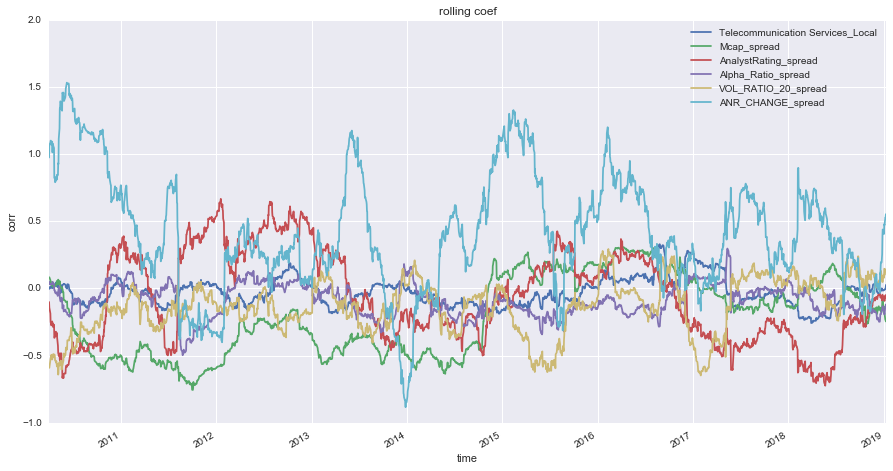

In [8]:
df_coef=model.df_coef
df_coef.index=pd.to_datetime(df_coef.index)
df_coef.drop(['intercept'],axis=1).dropna(how='all').plot()
_=plt.xlabel('time')
_=plt.ylabel('corr')
_=plt.title('rolling coef')

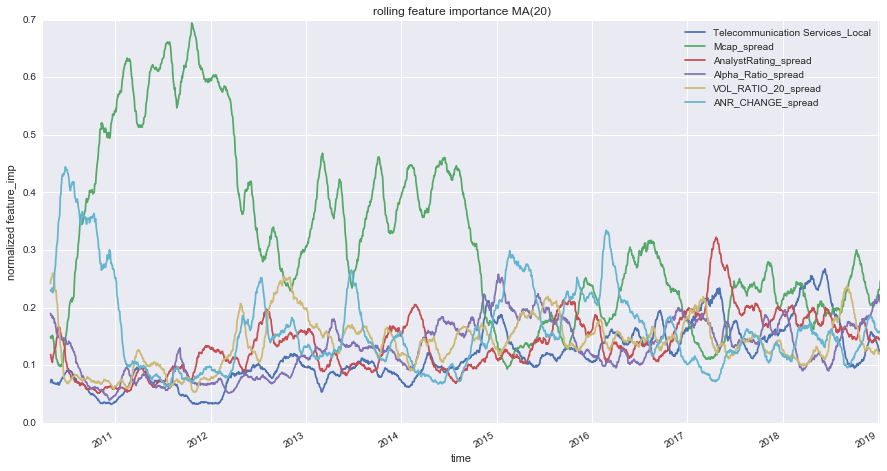

In [9]:
df_feature_imp=model.df_feature_imp
df_feature_imp.index=pd.to_datetime(df_feature_imp.index)
df_feature_imp.dropna(how='all').rolling(20).mean().plot()
_=plt.xlabel('time')
_=plt.ylabel('normalized feature_imp')
_=plt.title('rolling feature importance MA(20)')